# Fetching Simple Electron Data

This demo uses ServiceX to fetch electron data from an ATLAS Z->ee and an Z->$\mu\mu$ xAOD dataset.

## Setup

You need to have an instance of `servicex` up and running. In this case, two ports need be open on the local machine - 5000 for the app, and 9000 for the object store. As of this release, that normally means `port-forward`ing from the `k8` cluster that is hosting `servicex`.

In [1]:
from func_adl import EventDataset
from func_adl_xAOD import use_exe_servicex

import uproot_methods
import matplotlib.pyplot as plt

import datetime

Next thing you need is an endpont. This is for a cache that is setup in a docker container. But you can point directly at the service (the protocol is identical). Here, we also decide which datasets we're interested in.

In [2]:
end_point = 'http://localhost:5000/servicex'
dataset_1 = EventDataset('localds://mc15_13TeV:mc15_13TeV.361106.PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee.merge.DAOD_STDM3.e3601_s2576_s2132_r6630_r6264_p2363_tid05630052_00')
dataset_2 = EventDataset('localds://mc15_13TeV:mc15_13TeV.361107.PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zmumu.merge.DAOD_STDM3.e3601_s2576_s2132_r6630_r6264_p2363_tid05630078_00')

### Function definitions

In [3]:
retrieve_data = lambda dataset : dataset \
        .Select('lambda e: (e.Electrons("Electrons"), e.Muons("Muons"))') \
        .Select('lambda ls: (ls[0].Select(lambda e: e.pt()), ls[0].Select(lambda e: e.eta()), ls[0].Select(lambda e: e.phi()), ls[0].Select(lambda e: e.e()),ls[1].Select(lambda m: m.pt()), ls[1].Select(lambda m: m.eta()), ls[1].Select(lambda m: m.phi()), ls[1].Select(lambda m: m.e()))') \
        .AsAwkwardArray(('ElePt', 'EleEta', 'ElePhi', 'EleE', 'MuPt', 'MuEta', 'MuPhi', 'MuE')) \
        .value(executor=lambda a: use_exe_servicex(a, endpoint=end_point))

def four_vector_e(leptons_per_event):
    four_vector = uproot_methods.TLorentzVectorArray.from_ptetaphi(
    leptons_per_event[b'ElePt'], leptons_per_event[b'EleEta'],
    leptons_per_event[b'ElePhi'], leptons_per_event[b'EleE'],
    )
    
    return four_vector
    
def four_vector_mu(leptons_per_event):
    four_vector = uproot_methods.TLorentzVectorArray.from_ptetaphi(
    leptons_per_event[b'MuPt'], leptons_per_event[b'MuEta'],
    leptons_per_event[b'MuPhi'], leptons_per_event[b'MuE'],
    )

    return four_vector

def organize_electrons(dataset):
    v_electrons = four_vector_e(dataset)
    v_electrons = v_electrons[v_electrons.counts >= 2]
    dielectrons = v_electrons[:, 0] + v_electrons[:, 1]
    
    return dielectrons

def organize_muons(dataset):
    v_muons = four_vector_mu(dataset)
    v_muons = v_muons[v_muons.counts >= 2]
    dimuons = v_muons[:, 0] + v_muons[:, 1]
    
    return dimuons
    
def plot_data(dielectrons, dimuons):
    plt.figure(figsize=(12, 6))
    plt.hist(dielectrons.mass/1000.0, bins=100, range=(0,200))
    plt.title('Di-Electron Mass')
    plt.xlabel('$m_{ee}$ [GeV]')
    plt.ylabel('Count')
    plt.show()

    plt.figure(figsize=(12,6))
    plt.hist(dimuons.mass/1000.0, bins=100, range=(0,200))
    plt.title('Di-Muon Mass')
    plt.xlabel('$m_{\mu\mu}$ [GeV]')
    plt.ylabel('Count')
    plt.show()

### Fetching the data and plotting it for the `Z->ee` dataset.

In [4]:
zee_dataset = retrieve_data(dataset_1)
zmm_dataset = retrieve_data(dataset_2)

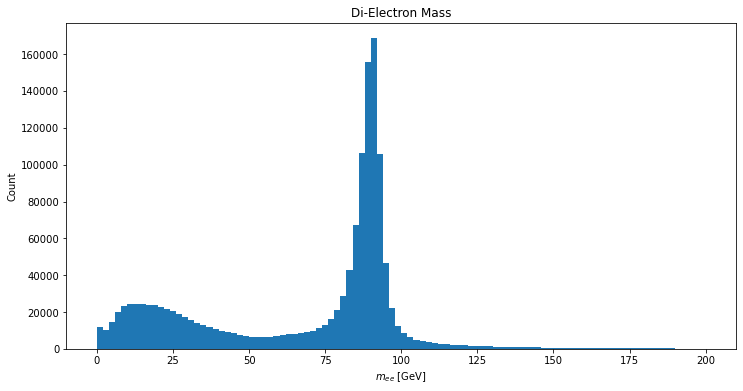

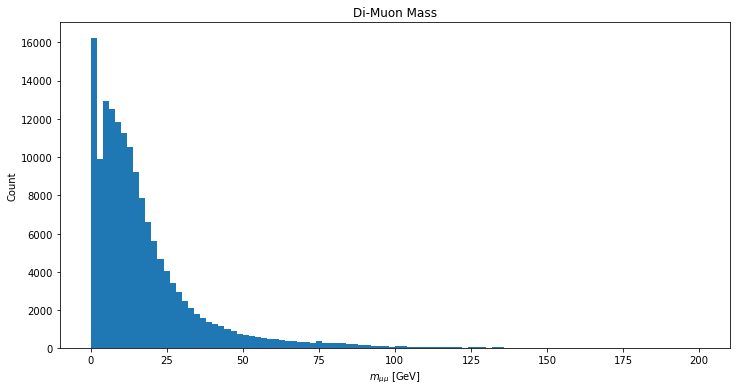

In [5]:
zee_die = organize_electrons(zee_dataset)
zee_dim = organize_muons(zee_dataset)

plot_data(zee_die, zee_dim)

### Fetching the dataset for Z->$\mu\mu$ and plotting it:

f:\program files (x86)\python 3.7\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
f:\program files (x86)\python 3.7\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


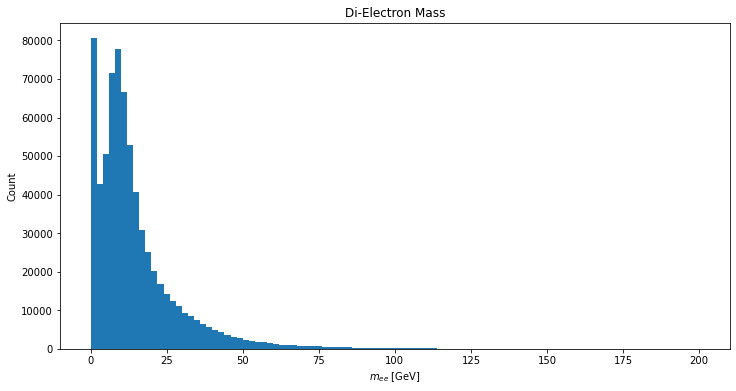

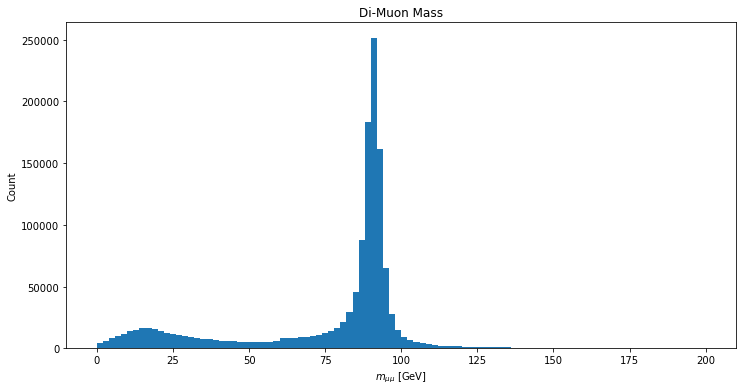

In [6]:
zmm_die = organize_electrons(zmm_dataset)
zmm_dim = organize_muons(zmm_dataset)

plot_data(zmm_die, zmm_dim)